<a href="https://colab.research.google.com/github/tonyzamyatin/learning-pytorch/blob/master/03_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03. PyTorch Computer Vision

Online Course Book: https://www.learnpytorch.io/03_pytorch_computer_vision/

In [3]:
# Import PyTorch
import torch

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.3.1
torchvision version: 0.18.1


## 1. Getting a dataset
For our first computer vision task we will go with the glorious FashionMNIST dataset, made by Zalando research. It contains low resolution grey scale images of 10 different kinds of clothing.

In [4]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data",  # where to download data
    train=True,  # get training data
    download=True,  # download data if it doesn't exist on disk
    transform=ToTensor(),  # images come as PIL format, we want to turn into Torch tensors
    target_transform=None  # don't transform the labels though
)

# Setup test data
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

Let's inspect the first sample of the training data.

In [5]:
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

### 1.1 Input and output shapes of a computer vision model

In [6]:
image.shape

torch.Size([1, 28, 28])

We have one color channel and a width and height of 28 pixels.

There is debate whether CHW or HWC is the better way to represent an image. Anyway, PyTorch accepts NCHW as default, but at the same time explains that NHWC performs better and is considered best practice.

In [7]:
# Number of samples
len(train_data), len(test_data)

(60000, 10000)

We have 60k training images and 10k test images.

In [8]:
# Inspect available classes
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Since we have 10 different classes. we're dealing with a multi-classification problem yet again.

### 1.2 Visualize our data

Image shape: torch.Size([1, 28, 28])


(-0.5, 27.5, 27.5, -0.5)

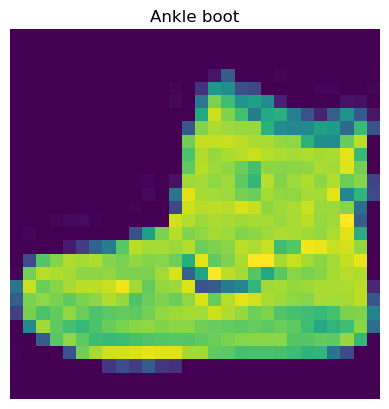

In [9]:
import matplotlib.pyplot as plt

image, label = train_data[0]
print(f"Image shape:", image.shape)
plt.imshow(image.squeeze())
plt.title(class_names[label])
plt.axis(False)

To turn images into greyscale we use the ˋcmapˋ parameter of ˋplt.imshow()ˋ.

(-0.5, 27.5, 27.5, -0.5)

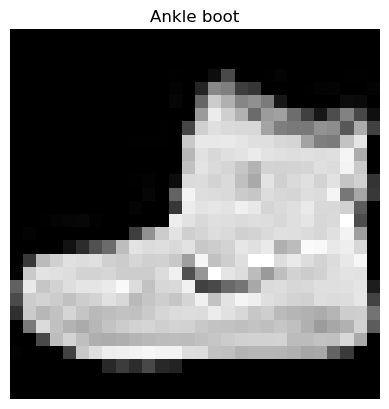

In [10]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)

Let's plot some more images.

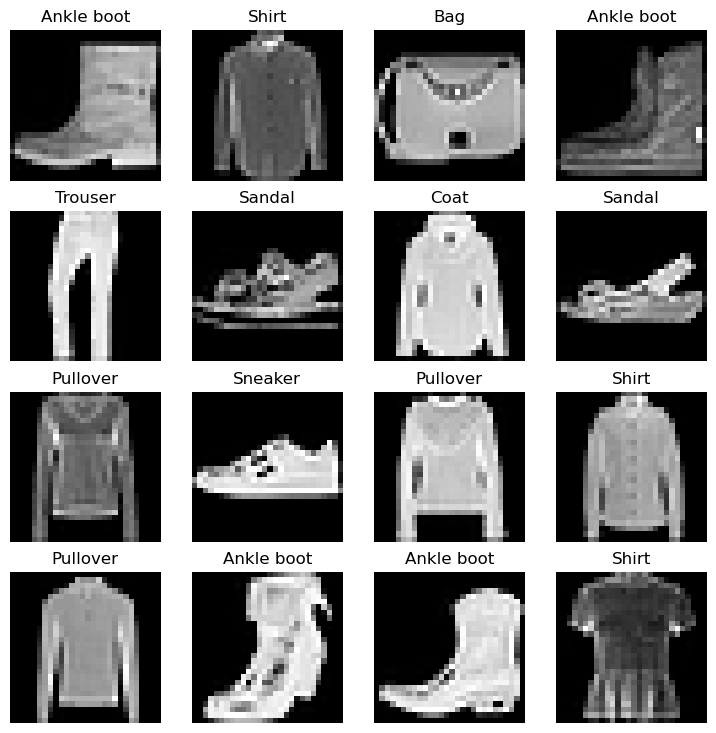

In [11]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

## 2. Prepare DataLoader

In [12]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dl = DataLoader(train_data, batch_size=BATCH_SIZE)
test_dl = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
print(f"Data loaders: {train_dl, test_dl}")
print(f"Length of train data loader: {len(train_dl)} batches of {BATCH_SIZE}...")
print(f"Length of test data loader: {len(test_dl)} batches of {BATCH_SIZE}...")

Data loaders: (<torch.utils.data.dataloader.DataLoader object at 0x0000026F990BEC10>, <torch.utils.data.dataloader.DataLoader object at 0x0000026F97B1A730>)
Length of train data loader: 1875 batches of 32...
Length of test data loader: 313 batches of 32...


## 3. Build a baseline model


In [13]:
from torch import nn


class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, hidden_units),
            nn.Linear(hidden_units, output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [14]:
torch.manual_seed(42)

model_0 = FashionMNISTModelV0(
    input_shape=784,
    hidden_units=10,
    output_shape=len(class_names)).to("cpu")

### 3.1 Setup loss, optimizer and evaluation metrics

In [15]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    # Note: you need the "raw" GitHub URL for this to work
    request = requests.get("https://raw.githubusercontent.com/tonyzamyatin/learning-pytorch/master/fcc-course/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

helper_functions.py already exists, skipping download


In [16]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.01)

### 3.2 Creating a function to time our experiments
Let's do a small experiment and compare the time it takes to run the model on a GPU versus on a CPU.

Our timing function will use ˋtimeit.default_timer()ˋ from the ˋtimeitˋ module.

In [17]:
from timeit import default_timer as timer


def print_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

### 3.3 Training loop on batches of data

In [18]:
from tqdm.auto import tqdm

torch.manual_seed(42)

# Measure time
train_time_start_on_cpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch + 1}\n---------")
    train_loss = 0
    for batch, (X, y) in enumerate(train_dl):
        model_0.train()
        y_pred = model_0(X)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dl.dataset)} samples")

    # Average loss per batch per epoch
    train_loss /= len(train_dl)

    # Testing
    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dl:
            test_pred = model_0(X_test)
            test_loss += loss_fn(test_pred, y_test)
            test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

        test_loss /= len(test_dl)
        test_acc /= len(test_dl)

    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

# Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(
    start=train_time_start_on_cpu,
    end=train_time_end_on_cpu,
    device="cpu"
)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1
---------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.00000 | Test loss: 0.50305, Test acc: 81.85%

Epoch: 2
---------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.00000 | Test loss: 0.50263, Test acc: 82.33%

Epoch: 3
---------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.00000 | Test loss: 0.51653, Test acc: 81.99%

Train time on cpu: 40.523 seconds


The baseline model did already do quite well. Let's evaluate the model.

## 4. Evaluate Model 0

In [19]:
!pip install torchmetrics


In [33]:
import torchmetrics
from typing import Tuple, Dict        

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               metrics: Dict[str, torchmetrics.Metric]) -> float:
    """
    Evaluates the model on the provided data_loader using the specified loss function and metrics.
    The function operates directly on the metrics and does not reset them such that the commuted metrics can be accessed though the references in the dictionary passed to this function.

    Args:
        model (torch.nn.Module): The model to be evaluated.
        data_loader (torch.utils.data.DataLoader): The data loader for the evaluation dataset.
        loss_fn (torch.nn.Module): The loss function to compute the loss.
        metrics (Dict[str, torchmetrics.Metric]): A dictionary of metrics to compute during evaluation.

    Returns:
        float: The average loss of the model on the dataset
    """

    model.eval()
    loss_total = 0.0
    
    with torch.inference_mode():
        for batch, (Xb, yb) in enumerate(data_loader):
            yb_pred = model(Xb)
            batch_loss = loss_fn(yb_pred, yb)
            loss_total += batch_loss.item()
            
            for metric in metrics.values():
                metric.update(yb_pred, yb)
    

    loss_avg = loss_total / len(data_loader) if len(data_loader) > 0 else 0.0

    return loss_avg

In [56]:
def print_eval_metrics(loss: float, metrics: Dict[str, torchmetrics.Metric], epoch: int=None):
    print()
    if epoch is not None:
        print(f"EPOCH {epoch}")
    print(f"Loss: {loss}")
    for name, metric in metrics.items():
        print(f"{name.capitalize()}: {metric.compute()}")
        
def filter_metrics(metrics: Dict[str, torchmetrics.Metric], exclude: str) -> Dict[str, torchmetrics.Metric]:
    return {name: metric for name, metric in metrics.items() if name != exclude}

EVALUATION of FashionMNISTModelV0

Loss: 0.5165258234206099
Accuracy: 0.8198999762535095
Recall: 0.8198999762535095
Precision: 0.8198999762535095
F1-score: 0.8198999762535095
Auroc: 0.9809557795524597


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Predicted class', ylabel='True class'>)

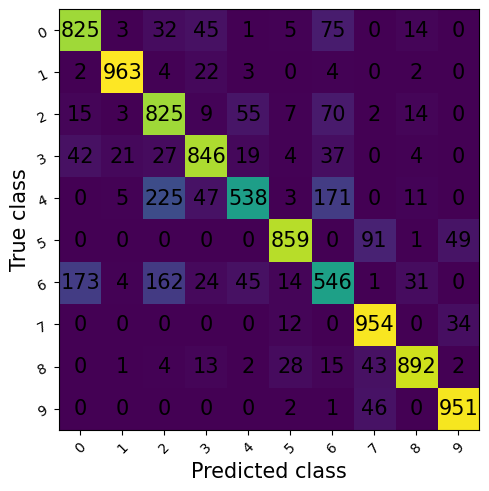

In [57]:
metrics = {
        "accuracy": torchmetrics.Accuracy(task="multiclass", num_classes=10),
        "recall": torchmetrics.Recall(task="multiclass", num_classes=10),
        "precision": torchmetrics.Precision(task="multiclass", num_classes=10),
        "f1-score": torchmetrics.F1Score(task="multiclass", num_classes=10),
        "auroc": torchmetrics.AUROC(task="multiclass", num_classes=10),
        "confmat": torchmetrics.ConfusionMatrix(task="multiclass", num_classes=10)
    }

loss = eval_model(model_0, test_dl, loss_fn, metrics)

print(f"EVALUATION of {model_0.__class__.__name__}")
print_eval_metrics(loss, filter_metrics(metrics, 'confmat'))

metrics['confmat'].plot()

## 5. Setup device agnostic-code

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 6. Model 1: Building a better model with non-linearity

In [24]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_size: int, hidden_units: int, output_size: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_size),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.layer_stack(x)

In [25]:
torch.manual_seed(42)

model_1 = FashionMNISTModelV1(28**2, 10, len(class_names)).to(device)

### 6.1 Setup loss, optimizer and metrics

In [58]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.01)
train_metrics = {
    "accuracy": torchmetrics.Accuracy(task="multiclass", num_classes=10),
    "f1_score": torchmetrics.F1Score(task="multiclass", num_classes=10)
} 
test_metrics = {
    "accuracy": torchmetrics.Accuracy(task="multiclass", num_classes=10),
    "recall": torchmetrics.Recall(task="multiclass", num_classes=10),
    "precision": torchmetrics.Precision(task="multiclass", num_classes=10),
    "f1_score": torchmetrics.F1Score(task="multiclass", num_classes=10),
    "auroc": torchmetrics.AUROC(task="multiclass", num_classes=10),
    "confmat": torchmetrics.ConfusionMatrix(task="multiclass", num_classes=10)
} 

In [59]:
def run_epoch(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer=None,
              metrics: Dict[str, torchmetrics.Metric]=None,
              device: torch.device = "cpu"):
    """
    Performs one epoch in a training or testing loop
    :param model: the model to run
    :param data_loader: the data loader of the data set
    :param optimizer: the optimizer to use. If `None` the model won't update gradients or the model's weights (e.g., testing)
    :param metrics: a dictionary of metrics to compute
    :param device: optional, the device to perform the computations on. Will use `cpu` per default 
    :return: the average loss of the model on the whole dataset
    """
    loss_total = 0.0
    model.train()
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        loss_total += loss
        if metrics is not None:
            for metric in metrics.values():
                metric.update(y_pred, y)
        
        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
          
    return loss_total / len(data_loader)

In [ ]:
torch.manual_seed(42)

from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"\nEPOCH {epoch+1}\n---------")
    train_loss = run_epoch(
        model=model_1,
        data_loader=train_dl,
        loss_fn=loss_fn,
        optimizer=optimizer,
        metrics=train_metrics,
        device=device
    )
    print("Training metrics:")
    print_eval_metrics(train_loss, train_metrics)
    
    print("Test metrics")
    test_loss = run_epoch(
        model=model_1,
        data_loader=test_dl,
        loss_fn=loss_fn,
        metrics=test_metrics,
        device=device
    )
    print_eval_metrics(test_loss, filter_metrics(test_metrics, 'confmat'))
    metrics['confmat'].plot()
    
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(train_time_start_on_gpu, train_time_end_on_gpu, device)